#CLIP모듈을 다양한 파이토치 데이터셋에 적용해 보았습니다.

In [1]:
!pip install ftfy regex tqdm #진행률을 눈으로 확인할 수 있는 모듈
!pip install git+https://github.com/openai/CLIP.git #CLIP import

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0kjbxgr3
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-0kjbxgr3
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=48b1bc194e0d8fd57ad3f428f4f200e2c609b9abcd1062b7452d53e1d83fce58
  Stored in directory: /tmp/pip-ephem-wheel-cache-7eajavty/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip


<h2>BaseLine

In [3]:
import os
import clip
import torch
from torchvision import datasets
from sklearn.metrics import accuracy_score

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu" #gpu 할당
model, preprocess = clip.load('ViT-B/32', device) # ViT를 이미지 인코더로 사용한 CLIP을 로딩.

# Download the dataset
cifar100 = datasets.CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False) #cifar 데이터 셋 불러오기
#accuracy lists
pred = [] #예측 값 담을 리스트
true = [] #실제 값 담을 리스트
# Prepare the inputs
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device) #CLIP에서 사용하는 모듈로 토크나이징 및 gpu 할당
for i in range(1):
  image, class_id = cifar100[i]
  image_input = preprocess(image).unsqueeze(0).to(device) #이미지 데이터 전처리 진행

  # Calculate features
  with torch.no_grad():
      image_features = model.encode_image(image_input) #이미지 인코딩
      text_features = model.encode_text(text_inputs) #텍스트 인코딩

  # Pick the top 5 most similar labels for the image
  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1) #유사도계산
  values, indices = similarity[0].topk(5) #결과값, 인덱스번호 할당

  # Print the result
  print("\nTop predictions:\n")
  #아래는 print문을 위한 코드

  switch=True
  for value, index in zip(values, indices):
      if switch==True: 
        pred.append(cifar100.classes[index])
        switch=False
      print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")
  print(f'{cifar100.classes[class_id]:>16s}')
  true.append(cifar100.classes[class_id])
accuracy_score(true, pred)



100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 123MiB/s]


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache

Top predictions:

    pickup_truck: 17.49%
        mountain: 14.73%
           train: 13.62%
            road: 9.51%
      lawn_mower: 4.78%
        mountain


0.0

image, text인코딩 후 결과는 어떻게 나오는지 확인해보자.

In [4]:
print(image_features.shape)
print(text_features.shape)

torch.Size([1, 512])
torch.Size([100, 512])


In [ ]:
similarity, similarity.shape

(tensor([[1.2941e-03, 1.8253e-03, 5.1994e-03, 3.5191e-03, 3.8862e-04, 5.9271e-04,
          6.5088e-04, 5.5351e-03, 1.7868e-02, 2.4567e-03, 2.7409e-03, 5.6229e-03,
          2.7252e-02, 1.5778e-02, 2.3079e-03, 1.4668e-03, 1.2941e-03, 1.6108e-03,
          1.0729e-03, 2.3441e-03, 3.4637e-03, 3.2210e-04, 1.2941e-03, 1.1185e-02,
          5.1498e-04, 7.7295e-04, 1.1606e-03, 5.2309e-04, 1.7691e-03, 3.4637e-03,
          2.2149e-04, 1.2550e-03, 4.0512e-03, 8.4877e-04, 7.6103e-04, 4.5891e-03,
          1.6623e-03, 1.3151e-03, 9.0361e-04, 2.9640e-03, 1.1425e-03, 4.7821e-02,
          4.7612e-04, 6.2132e-04, 2.1019e-03, 1.2624e-04, 6.0806e-03, 1.5135e-03,
          4.0283e-02, 1.4734e-01, 4.3793e-03, 8.2302e-04, 1.3781e-03, 5.4789e-04,
          1.6713e-04, 1.0794e-04, 2.6150e-03, 1.0405e-03, 1.7493e-01, 1.7868e-02,
          4.2877e-02, 6.6757e-03, 1.3351e-03, 4.8375e-04, 7.7295e-04, 2.5349e-03,
          7.2622e-04, 1.8253e-03, 9.5093e-02, 1.1185e-02, 8.4877e-04, 2.8267e-03,
          1.3781

In [ ]:
Dataset = [datasets.CIFAR100,datasets.CIFAR10,datasets.MNIST,datasets.FashionMNIST,datasets.KMNIST,datasets.Food101, datasets.StanfordCars]

test 데이터셋의 상위 100개 데이터를 대상으로 zero-shot 예측을 진행하고 그 accuracy를 측정해 보았습니다.

In [ ]:
import os
import clip
import torch
from torchvision import datasets
from sklearn.metrics import accuracy_score

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)
ACC=[]
# Download the dataset
for _ in Dataset:
  try:
    data = _(root='./data', download=True, train=False)
  except:
    data = _(root='./data',  split='test', download=True)

  #accuracy lists
  pred = []
  true = []
  # Prepare the inputs
  text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in data.classes]).to(device)
  for i in range(100):
    image, class_id = data[i]
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Calculate features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Pick the top 5 most similar labels for the image
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)

    for value, index in zip(values, indices):
        pred.append(data.classes[index])
    true.append(data.classes[class_id])
  ACC.append(f'{data.__class__.__name__} : {accuracy_score(true, pred)}')
for i in ACC:
  print(i)

Files already downloaded and verified
Files already downloaded and verified
CIFAR100 : 0.69
CIFAR10 : 0.91
MNIST : 0.38
FashionMNIST : 0.62
KMNIST : 0.1
Food101 : 0.89
StanfordCars : 0.59


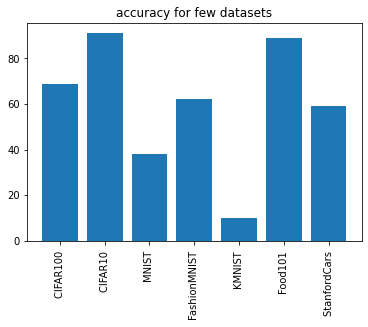

In [ ]:
import matplotlib.pyplot as plt
y_lst = []
x_lst = []
for j in ACC:
  x, y = j.split(':')
  y = float(y)*100
  x_lst.append(x)
  y_lst.append(y)
plt.title('accuracy for few datasets')
plt.xticks(rotation=90)
plt.bar(x_lst,y_lst)
plt.show()


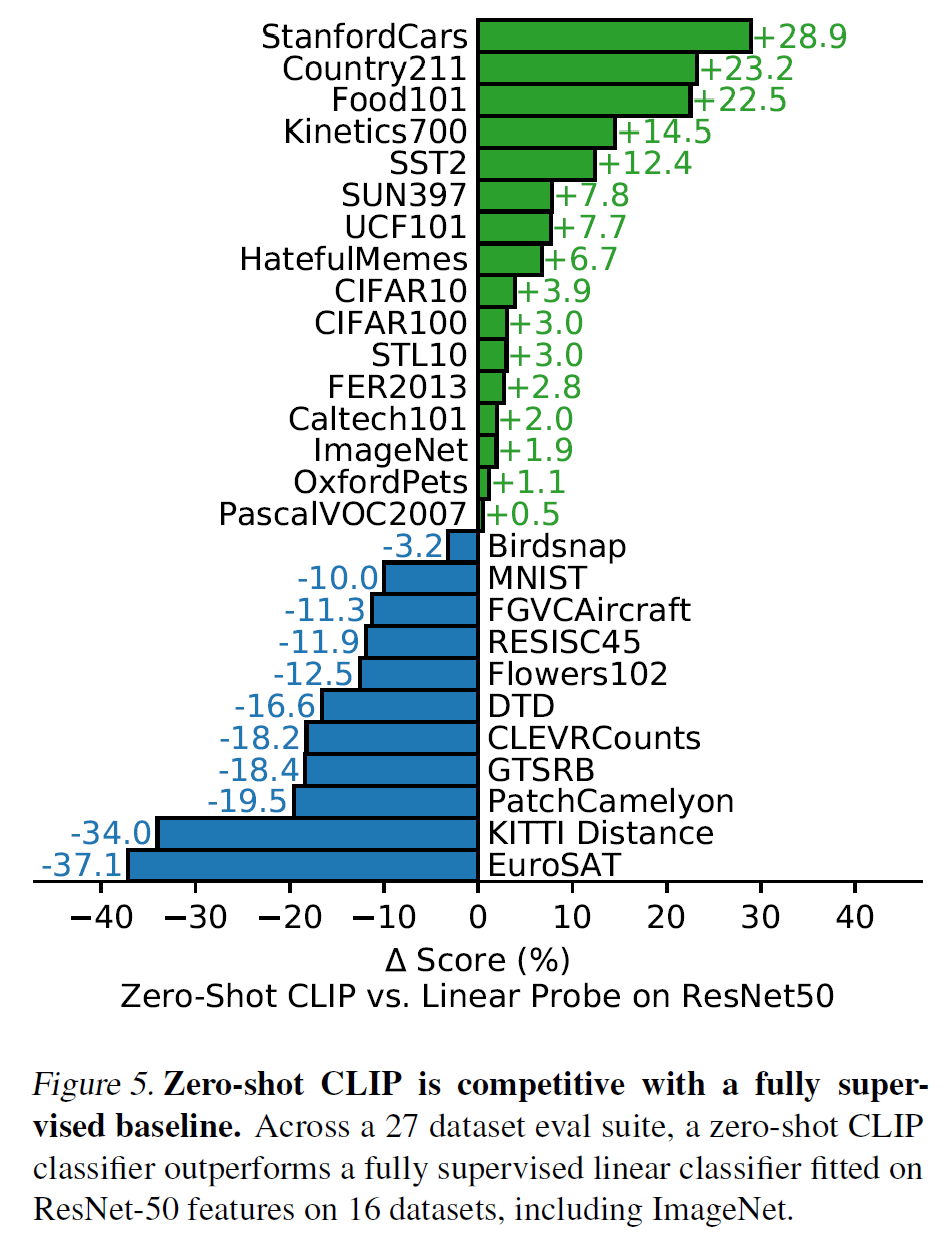

Resnet과 비교했던 데이터를 포함한 여러 데이터를 가져와서 100개만 셈플 후 accuracy를 계산해보았음. CIFAR10, Food101의 경우는 사실상 일반적인 CNN툴로 학습을 시키는 것보다 훨씬 우수한 성과를 보였다.

few-shot learning 이후의 성과를 확인하고자 logistic 적용된 python파일에도 같은 데이터 셋들을 적용해 보았다.

In [ ]:
import os
import clip
import torch

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from tqdm import tqdm

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)
ACC_2 = []

def get_features(dataset):
    all_features = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Load the dataset
root = os.path.expanduser("~/.data")
for _ in Dataset:
  try:
    train = _(root, download=True, train=True, transform=preprocess)
    test = _(root, download=True, train=False, transform=preprocess)
  except:
    train = _(root, download=True, split='train', transform=preprocess)
    test = _(root, download=True, split='test', transform=preprocess)

  # Calculate the image features
  train_features, train_labels = get_features(train)
  test_features, test_labels = get_features(test)

  # Perform logistic regression
  classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
  classifier.fit(train_features, train_labels)

  # Evaluate using the logistic regression classifier
  predictions = classifier.predict(test_features)
  accuracy = np.mean((test_labels == predictions).astype(np.float)) * 100.
  ACC_2.append(f'{train.__class__.__name__} : {accuracy}')
  print(f"Accuracy = {accuracy:.3f}")

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 100/100 [00:20<00:00,  4.85it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.2min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted t

Accuracy = 79.960


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /root/.data/cifar-10-python.tar.gz to /root/.data
Files already downloaded and verified


100%|██████████| 100/100 [00:20<00:00,  4.81it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted t

Accuracy = 95.010


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/.data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/.data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/.data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.data/MNIST/raw



100%|██████████| 100/100 [00:18<00:00,  5.41it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Accuracy = 98.500


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.data/FashionMNIST/raw



100%|██████████| 100/100 [00:17<00:00,  5.63it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted t

Accuracy = 90.420


  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting /root/.data/KMNIST/raw/train-images-idx3-ubyte.gz to /root/.data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting /root/.data/KMNIST/raw/train-labels-idx1-ubyte.gz to /root/.data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting /root/.data/KMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting /root/.data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.data/KMNIST/raw



100%|██████████| 100/100 [00:17<00:00,  5.66it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted t

Accuracy = 83.380


  0%|          | 0/4996278331 [00:00<?, ?it/s]

Extracting /root/.data/food-101.tar.gz to /root/.data


100%|██████████| 253/253 [03:42<00:00,  1.14it/s]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 18.2min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted t

Accuracy = 88.202


  0%|          | 0/330960 [00:00<?, ?it/s]

Extracting /root/.data/stanford_cars/car_devkit.tgz to /root/.data/stanford_cars


  0%|          | 0/979269282 [00:00<?, ?it/s]

Extracting /root/.data/stanford_cars/cars_train.tgz to /root/.data/stanford_cars
Using downloaded and verified file: /root/.data/stanford_cars/car_devkit.tgz
Extracting /root/.data/stanford_cars/car_devkit.tgz to /root/.data/stanford_cars


  0%|          | 0/977350468 [00:00<?, ?it/s]

Extracting /root/.data/stanford_cars/cars_test.tgz to /root/.data/stanford_cars


  0%|          | 0/185758 [00:00<?, ?it/s]

100%|██████████| 81/81 [01:51<00:00,  1.37s/it]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy = 80.873


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
ACC_2

['CIFAR100 : 79.96',
 'CIFAR10 : 95.00999999999999',
 'MNIST : 98.5',
 'FashionMNIST : 90.42',
 'KMNIST : 83.38',
 'Food101 : 88.2019801980198',
 'StanfordCars : 80.87302574306679']

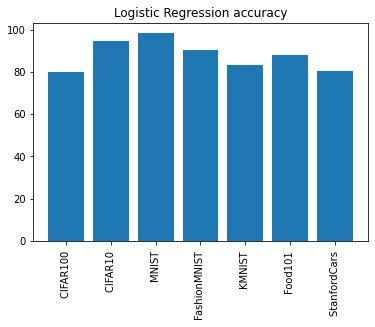

In [ ]:
import matplotlib.pyplot as plt
y_lst2 = []
x_lst2 = []
for j in ACC_2:
  x, y = j.split(':')
  y = float(y)
  x_lst2.append(x)
  y_lst2.append(y)
plt.title('Logistic Regression accuracy')
plt.xticks(rotation=90)
plt.bar(x_lst2,y_lst2)
plt.show()


Zeroshot , Logistic Regression 정확도 비교

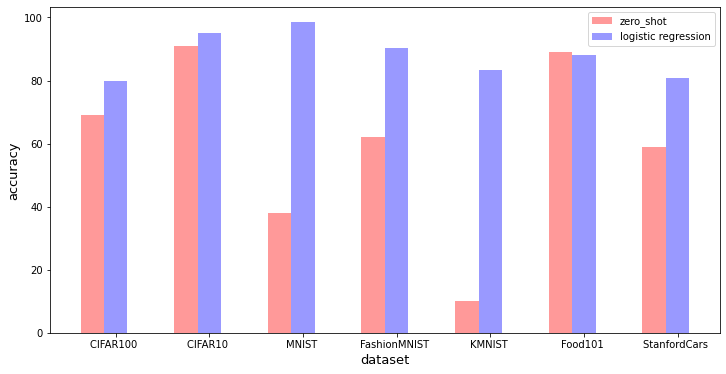

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
bar_width = 0.25

index = np.arange(len(x_lst))

b1 = plt.bar(index, y_lst, bar_width, alpha=0.4, color='red', label='zero_shot')

b2 = plt.bar(index + bar_width, y_lst2, bar_width, alpha=0.4, color='blue', label='logistic regression')


plt.xticks(np.arange(bar_width, len(x_lst2) + bar_width, 1), x_lst2)

plt.xlabel('dataset', size = 13)
plt.ylabel('accuracy', size = 13)
plt.legend()
plt.show()

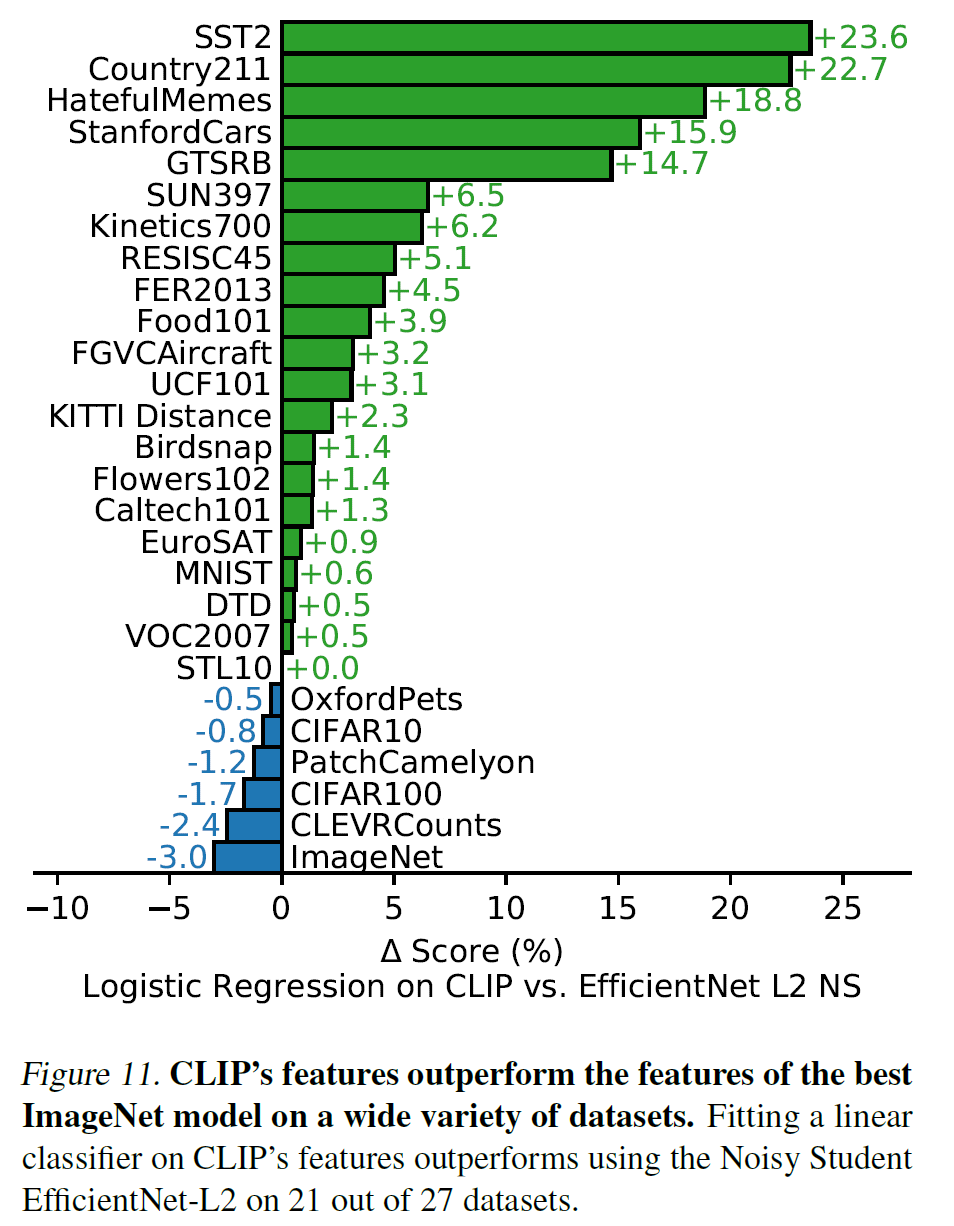

Few-shot Learning을 진행했을 때, 성과가 훨씬 높았고, food101 등의 큰 데이터에 대한 학습 시간도 약 10분 내외로 굉장히 우수하였다. 